## 4.1 EDA and data preprocessing 	(5b)

In [68]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import load_model

In [5]:
SEED = 565324
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
TRAIN_DATASET_DIR = os.path.join("Covid19-dataset", "train")
TEST_DATASET_DIR = os.path.join("Covid19-dataset", "test")

classes = ["Covid", "Normal", "Viral Pneumonia"]

### (A-4b)	EDA a data preprocessing pre Vami vybrané charakteristiky z datasetu

In [7]:
# Count images per class
train_class_counts = {}
test_class_counts = {}

for cls in classes:
    class_path = os.path.join(TRAIN_DATASET_DIR, cls)
    train_class_counts[cls] = len(os.listdir(class_path))

for cls in classes:
    class_path = os.path.join(TEST_DATASET_DIR, cls)
    test_class_counts[cls] = len(os.listdir(class_path))


print(f"Train class counts: {train_class_counts}")
print(f"Test class counts: {test_class_counts}")

Train class counts: {'Covid': 111, 'Normal': 70, 'Viral Pneumonia': 70}
Test class counts: {'Covid': 26, 'Normal': 20, 'Viral Pneumonia': 20}


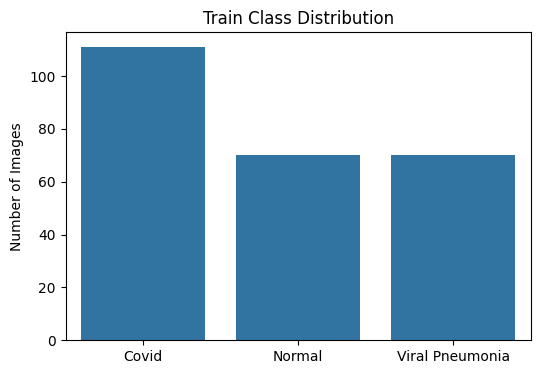

In [8]:
# Vissualise per class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=list(train_class_counts.keys()), y=list(train_class_counts.values()))
plt.title("Train Class Distribution")
plt.ylabel("Number of Images")
plt.show()


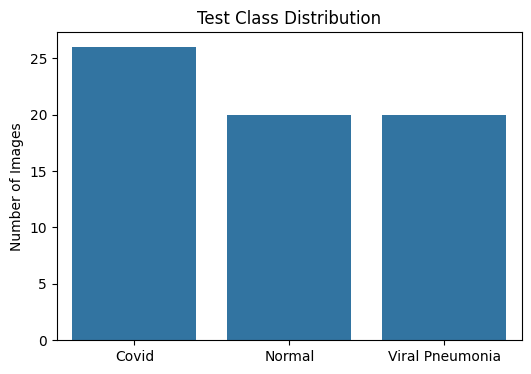

In [9]:
# Vissualise per class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=list(test_class_counts.keys()), y=list(test_class_counts.values()))
plt.title("Test Class Distribution")
plt.ylabel("Number of Images")
plt.show()

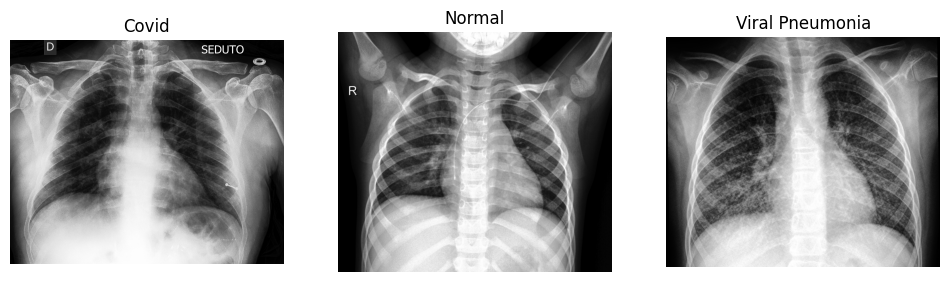

In [10]:
# Show sample images
plt.figure(figsize=(12,4))

for i, cls in enumerate(classes):
    class_path = os.path.join(TRAIN_DATASET_DIR, cls)
    img_name = os.listdir(class_path)[0]
    img = plt.imread(os.path.join(class_path, img_name))
    
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(cls)
    plt.axis("off")

plt.show()


In [11]:
# Image Preprocessing + Dataset Loading
IMG_SIZE = 224

x_train = []
x_test = []
y_train = []
y_test = []

for label, cls in enumerate(classes):
    # Train Set
    folder = os.path.join(TRAIN_DATASET_DIR, cls)
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        
        # load image
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        x_train.append(img)
        y_train.append(label)

    # Test Set
    folder = os.path.join(TEST_DATASET_DIR, cls)
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        
        # load image
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        x_test.append(img)
        y_test.append(label)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 


((251, 224, 224, 3), (66, 224, 224, 3), (251,), (66,))

In [12]:
# Normalize images
x_train = x_train / 255.0   # scale to [0,1]
x_test = x_test / 255.0


In [13]:
# train, validation split  
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

In [14]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32)


### (B-1b)	Zdôvodnite výber ML/DL metód vzhľadom na Vami vybraný dataset pre 4.2

The Covid-19 image dataset consists of chest X-ray images with three classes: Covid, Normal, and Viral Pneumonia. 

Considering the dataset characteristics:

1. **Image-based data**: The dataset contains images, which are best handled by Convolutional Neural Networks (CNNs) because CNNs automatically extract spatial features like edges, textures, and patterns, which are crucial for detecting medical anomalies in X-rays.

2. **Moderate dataset size**: The dataset is relatively small (~166 MB), so training a deep CNN from scratch may lead to overfitting. Therefore, **transfer learning** using pretrained models (e.g., EfficientNet, ResNet, DenseNet) is appropriate. These models have already learned general image features and can be fine-tuned for our specific task.

3. **Three-class classification**: CNNs with a softmax classifier are well-suited for multi-class problems like this one.

4. **Medical application**: High recall for Covid detection is critical. CNNs, especially with augmentation and class weighting, help improve sensitivity.

**Conclusion**:  
For this dataset, using **transfer learning with a pretrained CNN** (e.g., EfficientNetB0) is optimal. As a baseline, a simple CNN can also be trained for comparison. This approach balances **accuracy, generalization, and computational efficiency**, making it suitable for our modeling task in section 4.2.


## 4.2. Modeling and evaluation (5b)

### (A-4b) Modeluje Vami tie vybrané charakteristiky pomocou vhodných ML/DL metód. Výsledok modelovania je najlepší model. 

In [15]:
best_model = Sequential([
    # First convolutional layer
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.16),

    # Second convolutional layer
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.16),

    # Third convolutional layer
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),

    # Output layer
    layers.Dense(3, activation='softmax')
])

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

best_model.summary()

c:\Users\Andrii\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Training

In [16]:
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', save_best_only=True, verbose=1)

history1 = best_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[model_checkpoint],
)


c:\Users\Andrii\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.3264 - loss: 3.5316
Epoch 1: val_loss improved from None to 1.09580, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 881ms/step - accuracy: 0.3333 - loss: 2.6295 - val_accuracy: 0.2692 - val_loss: 1.0958
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.3614 - loss: 1.0793
Epoch 2: val_loss improved from 1.09580 to 1.05221, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 752ms/step - accuracy: 0.4000 - loss: 1.0642 - val_accuracy: 0.5385 - val_loss: 1.0522
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.6295 - loss: 1.0216
Epoch 3: val_loss improved from 1.05221 to 1.04143, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 737ms/step - accuracy: 0.6533 - loss: 1.0238 - val_accuracy: 0.8462 - val_loss: 1.0414
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.6258 - loss: 0.9757
Epoch 4: val_loss improved from 1.04143 to 0.80530, saving model t

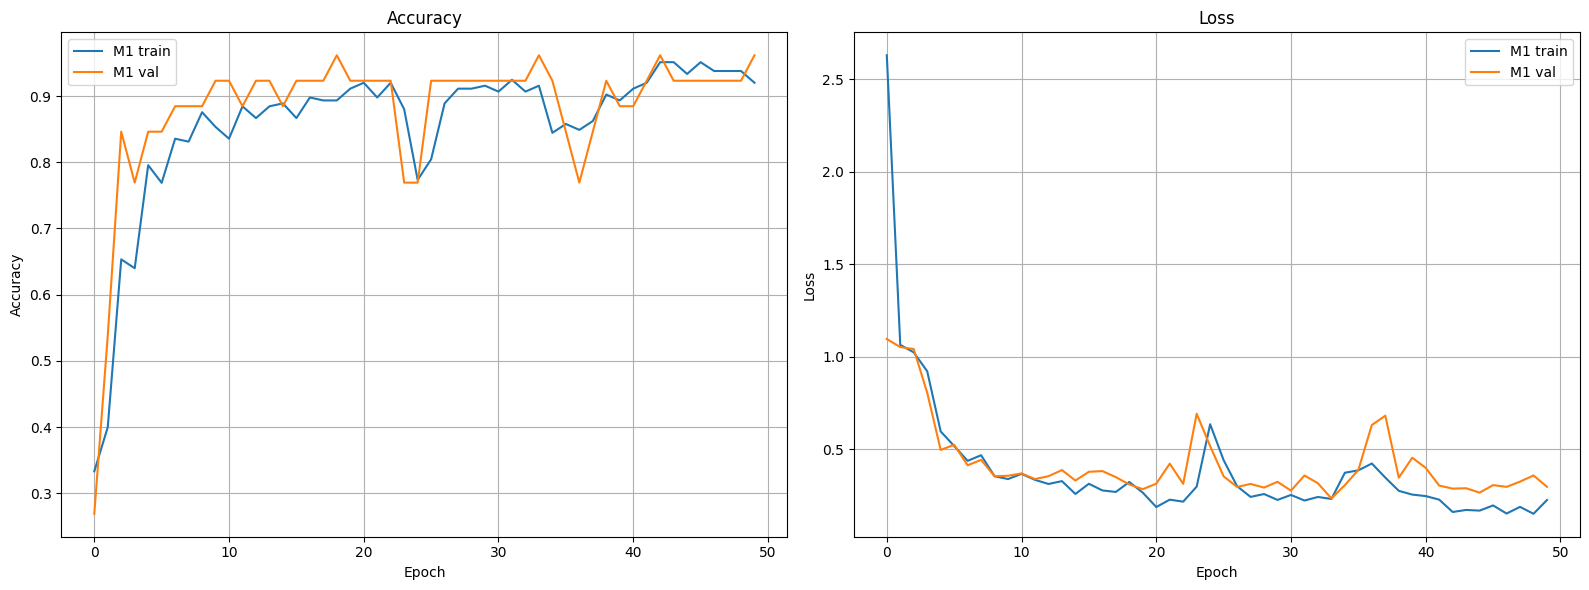

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(history1.history['accuracy'], label='M1 train')
ax1.plot(history1.history['val_accuracy'], label='M1 val')
ax1.set_title('Accuracy'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy'); ax1.grid(True); ax1.legend()

ax2.plot(history1.history['loss'], label='M1 train')
ax2.plot(history1.history['val_loss'], label='M1 val')
ax2.set_title('Loss'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss'); ax2.grid(True); ax2.legend()

plt.tight_layout(); plt.show()

In [18]:
# Load the best model
best_model = load_model('best_model.keras')

y_pred = best_model.predict(x_test).argmax(axis=1)
loss, acc = best_model.evaluate(x_test, y_test, verbose=0)

results_df = pd.DataFrame([{
    'Test Loss': round(loss, 3),
    'Test Accuracy': f"{round(acc*100, 3)}%",
}])

print("TEST RESULTS:")
print(results_df.to_string(index=False))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
TEST RESULTS:
 Test Loss Test Accuracy
     0.213       90.909%


Classification Report

In [19]:
print(classification_report(y_test, y_pred, target_names=classes))

                 precision    recall  f1-score   support

          Covid       1.00      0.88      0.94        26
         Normal       0.80      1.00      0.89        20
Viral Pneumonia       0.94      0.85      0.89        20

       accuracy                           0.91        66
      macro avg       0.91      0.91      0.91        66
   weighted avg       0.92      0.91      0.91        66



Confusion Matrix

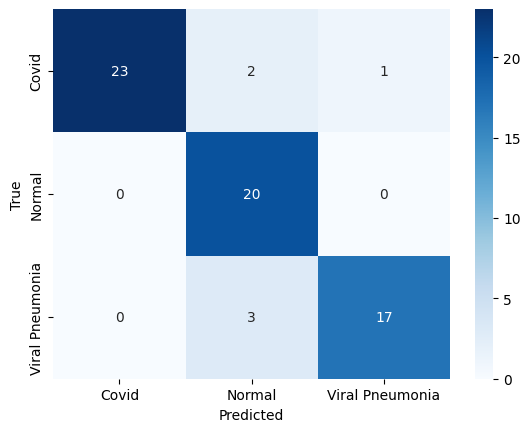

In [20]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

Show errors

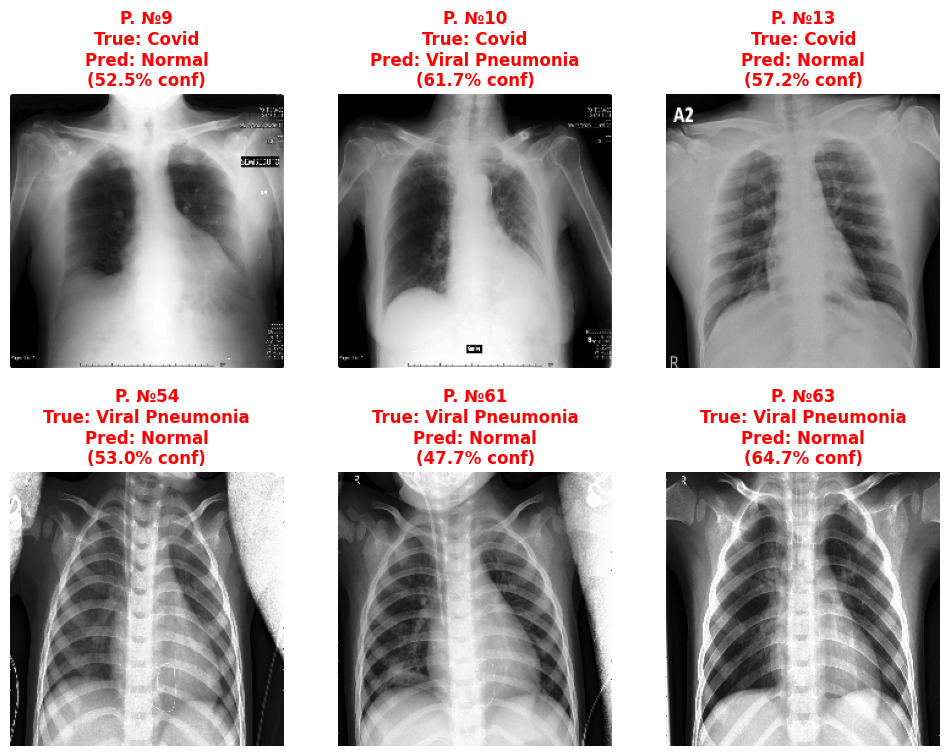

In [67]:
errors = np.where(y_pred != y_test)[0]
fig, axes = plt.subplots(2, 3, figsize=(12, 9))

for i, ax in enumerate(axes.flat):
    ax.axis('off')
    if i < len(errors):
        idx = errors[i]
        probs = best_model.predict(x_test[idx:idx+1], verbose=0)[0]
        ax.imshow(x_test[idx])
        ax.set_title(
            f"P. №{idx}\nTrue: {classes[y_test[idx]]}\nPred: {classes[y_pred[idx]]}\n({probs[y_pred[idx]]*100:.1f}% conf)",
            color='red', 
            fontweight='bold'
        )

plt.show()

### (B-1b) Zhodnotíte Váš prístup a získaný výsledok 

Multiple training parameters were tested and the best model was selected. 
ModelCheckpoint callback with SEED=565324 was used to ensure reproducibility.

The model consists of three convolutional layers (Conv2D) with progressively increasing filter counts (32, 64, 128). MaxPooling layers are used between them to reduce spatial dimensions, and Dropout layers (0.16, 0.16, 0.2) are applied for regularization and overfitting prevention.

**Obtained Results:**
- Test Accuracy: 90.91%
- Test Loss: 0.213
- Weighted avg F1-score: 0.91
- Macro avg F1-score: 0.91

**Classification Report**
```python
                 precision    recall  f1-score   support

          Covid       1.00      0.88      0.94        26
         Normal       0.80      1.00      0.89        20
Viral Pneumonia       0.94      0.85      0.89        20

       accuracy                           0.91        66
      macro avg       0.91      0.91      0.91        66
   weighted avg       0.92      0.91      0.91        66
```

A small difference (~2%) between training and validation accuracy indicates model stability without signs of overfitting or underfitting. The low test loss (0.213) and balanced results confirm this.

The model achieves good results and is stable without overfitting or underfitting.